In [446]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.family'] = 'serif'
plt.rcParams['figure.facecolor'] = 'white'
import scipy.interpolate as interpolate
from scipy.signal import savgol_filter
from tqdm import tqdm

## Discrete Hopfield

Asynchronous updating (one unit updated at a time)

In [681]:
@njit
def random_config(L, p=0.5):
    """ Creates a random array of spins with values +1 and -1. Default probability is 0.5 for +1. 
        L: Length of array of spins
    """
    array =  np.ones(L)
    for i in range(L):
        r = np.random.uniform(0,1)
        if r>p:
            array[i] *= -1

    return array

In [793]:
@njit
def energy(spins, w):
    H = 0
    for i in range(L):
        for j in range(L):
            H += w[i][j] * spins[i] * spins[j]
    H = -0.5*H
    return H

@njit
def hop_sweep(spins, w, beta, T):
    L = np.shape(spins)[0]
    for i in range(L):
        rdm_spin = int(L*np.random.uniform(0,1))
        # Discrete
        # spins[rdm_spin] = np.sum(w[rdm_spin]*spins) / abs(np.sum(w[rdm_spin]*spins))
        h_i = np.sum(w[rdm_spin]*spins)
        if h_i>=0:
            spins[rdm_spin] = 1
        else:
            spins[rdm_spin] = -1

        # Continuous
        # spins[rdm_spin] = np.tanh(beta*np.sum(w[rdm_spin]*spins))
        
        # Stochastic
        # h_i = np.sum(w[rdm_spin]*spins)
        # f_p = 1/(1+ np.exp(-2*h_i/T))
        # r = np.random.uniform(0,1)
        # if r<= f_p:
        #     spins[rdm_spin] = 1
        # else:
        #     spins[rdm_spin] = -1
        
    return spins

@njit
def hop_run(pattern, beta=50, T=0.04, N=1000):
    shape_arr = np.shape(pattern)
    if len(shape_arr)==2:  # multiple patterns stored
        num_pat, L = np.shape(pattern)
        w = np.zeros((L,L))  # setting the weight array
        for j in range(num_pat):
            for i in range(L):  
                w[i] += pattern[j]*pattern[j][i]/L
                w[i,i] = 0
                
    elif len(shape_arr)==1:  # only one pattern stored
        L = np.shape(pattern)[0]
        w = np.zeros((L,L))  # setting the weight array
        for i in range(L):  
            w[i] = pattern*pattern[i]/L
            w[i,i] = 0

    initial_spins =  random_config(L)

    spins = np.copy(initial_spins)
    H_arr = np.zeros(N+1)
    H_arr[0] = energy(spins, w)

    for i in range(N):
        spins = hop_sweep(spins, w, beta, T)
        H_arr[i+1] = energy(spins, w)
        
    return spins, pattern, H_arr, initial_spins

Number of patterns: 5
Failed!


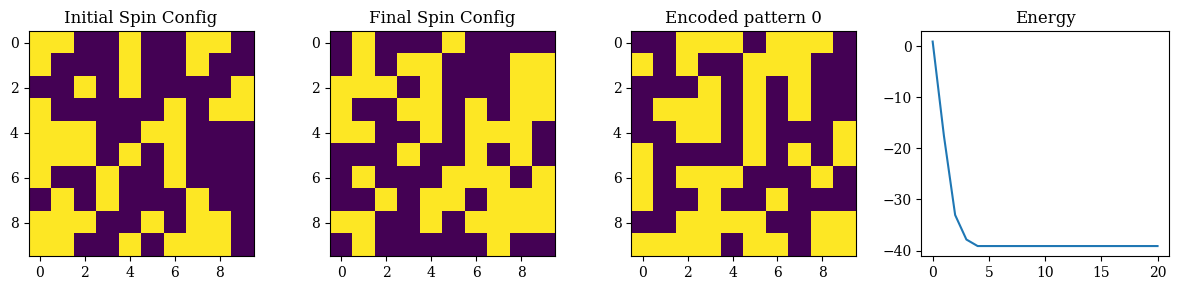

CPU times: user 629 ms, sys: 16.4 ms, total: 646 ms
Wall time: 261 ms


In [819]:
%%time
sqr = 10
L = sqr**2
num_pat = 5
print("Number of patterns:", num_pat)

# creating random patterns to find
pat_arr =  np.ones((num_pat,L))
for j in range(num_pat):
    pat_arr[j] = random_config(L)  

spins, pattern, H_arr, init = hop_run(pattern=pat_arr, T=0.1, N=20)

match = 0
for i in range(num_pat):
    if all(spins==pattern[i]) or all(-spins==pattern[i]):
        print("Matched with pattern number", i+1)
        match = i+1
        break
if match == 0:
    print("Failed!")
        
    
spins_grid = spins.reshape(sqr,sqr)
pattern_grid = pattern[i].reshape(sqr,sqr)

fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(12,3))
ax[0].imshow(init.reshape(sqr, sqr))
ax[0].set_title("Initial Spin Config")
ax[1].imshow(spins_grid)
ax[1].set_title("Final Spin Config")
ax[2].imshow(pattern_grid)
ax[2].set_title("Encoded pattern "+str(match))
# ax[3].imshow(abs(pattern_grid+spins_grid))
# ax[3].set_title("|Pattern-spins|")
ax[3].plot(H_arr)
ax[3].set_title('Energy')
# ax[3].set_aspect('equal', adjustable='box')
plt.tight_layout()
plt.show()

# Continuous

In [783]:
a = np.array([[1,2,3], [3,4,5]])
b = np.array([5,6,7])
np.dot(a,b)

array([38, 74])

In [789]:
@njit
def hop_sweep(spins, w, T, pattern):
    L = np.shape(spins)[0]
    for i in range(L):
        rdm_spin = int(L*np.random.uniform(0,1))
    #     spins[rdm_spin] = np.tanh(np.sum(w[rdm_spin]*spins)/T)
        z = np.dot(pattern, spins)
        spins[rdm_spin] = np.dot(pattern.T[rdm_spin], np.exp(z/T)/np.sum(np.exp(z/T)))
    # spins = np.tanh(np.dot(w*spins)/T)
    # spins = (np.dot(w,np.tanh(spins)) - spins)*0.01 + spins
    # spins = (np.tanh(np.dot(w,spins)/T) - spins)*0.01 + spins
    return spins

@njit
def hop_run(pattern, T=0.04, N=1000):
    shape_arr = np.shape(pattern)
    if len(shape_arr)==2:  # multiple patterns stored
        num_pat, L = np.shape(pattern)
        w = np.zeros((L,L))  # setting the weight array
        for j in range(num_pat):
            for i in range(L):  
                w[i] += pattern[j]*pattern[j][i]/L
                w[i,i] = 0
                
    elif len(shape_arr)==1:  # only one pattern stored
        L = np.shape(pattern)[0]
        w = np.zeros((L,L))  # setting the weight array
        for i in range(L):  
            w[i] = pattern*pattern[i]/L
            w[i,i] = 0
    initial_spins =  np.random.uniform(-1,1,L)

    spins = np.copy(initial_spins)
    H_arr = np.zeros(N+1)
    H_arr[0] = energy(spins, w)
    
    for i in range(N):
        spins = hop_sweep(spins, w, T, pattern)
        H_arr[i+1] = energy(spins, w)
        # print(spins)
    return spins, pattern, H_arr

Number of patterns: 5
Matched with pattern number 2


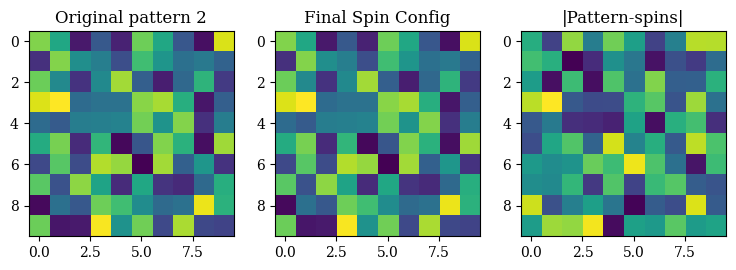

CPU times: user 405 ms, sys: 7.95 ms, total: 413 ms
Wall time: 163 ms


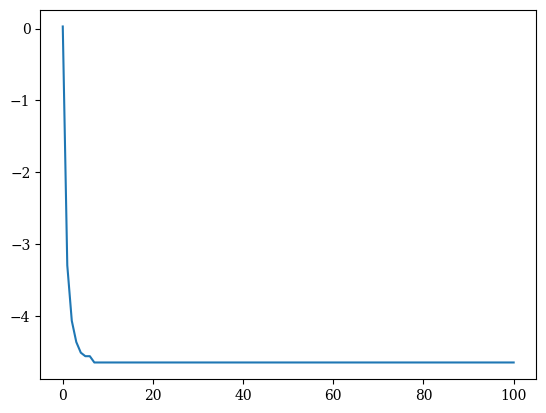

In [792]:
%%time
sqr = 10
L = sqr**2
num_pat = 5
print("Number of patterns:", num_pat)

# creating random patterns to find
pat_arr = np.ones((num_pat,L))
for j in range(num_pat):
    pat_arr[j] = np.random.uniform(-1,1,L)

spins, pattern, H_arr = hop_run(pattern=pat_arr, T=0.1, N=100)

match = 0
for i in range(num_pat):
    if all(spins==pattern[i]) or all(-spins==pattern[i]):
        print("Matched with pattern number", i+1)
        match = i+1
        break
if match == 0:
    print("Failed!")
        
    
spins_grid = spins.reshape(sqr,sqr)
pattern_grid = pattern[i].reshape(sqr,sqr)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(9,3))
ax[0].imshow(pattern_grid)
ax[0].set_title("Original pattern "+str(match))
ax[1].imshow(spins_grid)
ax[1].set_title("Final Spin Config")
ax[2].imshow(abs(pattern_grid+spins_grid))
ax[2].set_title("|Pattern-spins|")
plt.show()
plt.plot(H_arr)


In [512]:
%%time
# sqr = 
L = 100
N_sweeps = 200
N_avg = 500
num_pat_arr = np.arange(1, int(0.2*L))
n_pattern = np.zeros_like(num_pat_arr)
n_inverse = np.zeros_like(num_pat_arr)
n_spurious = np.zeros_like(num_pat_arr)
energy_arr = np.zeros(shape=(len(num_pat_arr), N_sweeps+1))

for npa in tqdm(range(0, len(num_pat_arr))):
    num_pat = num_pat_arr[npa]

    for avg_no in range(0, N_avg):
        # creating random patterns
        pat_arr =  np.ones((num_pat,L))
        for j in range(num_pat):
            pat_arr[j] = random_config(L)  
        
        spins, pattern, H_arr = hop_run(pattern=pat_arr, T=0.01, N=N_sweeps)
        energy_arr[npa] += H_arr/N_avg
        
        match = 0
        for i in range(num_pat):
            if all(spins==pattern[i]): 
                n_pattern[npa] += 1
                match = i+1
                break
            elif all(-spins==pattern[i]):
                n_inverse[npa] += 1
                match = i+1
        if match == 0:
            n_spurious[npa] +=1

n_pattern = n_pattern/N_avg
n_inverse = n_inverse/N_avg
n_spurious = n_spurious/N_avg

100%|███████████████████████████████████████████| 19/19 [00:55<00:00,  2.91s/it]

CPU times: user 54.9 s, sys: 279 ms, total: 55.2 s
Wall time: 55.3 s


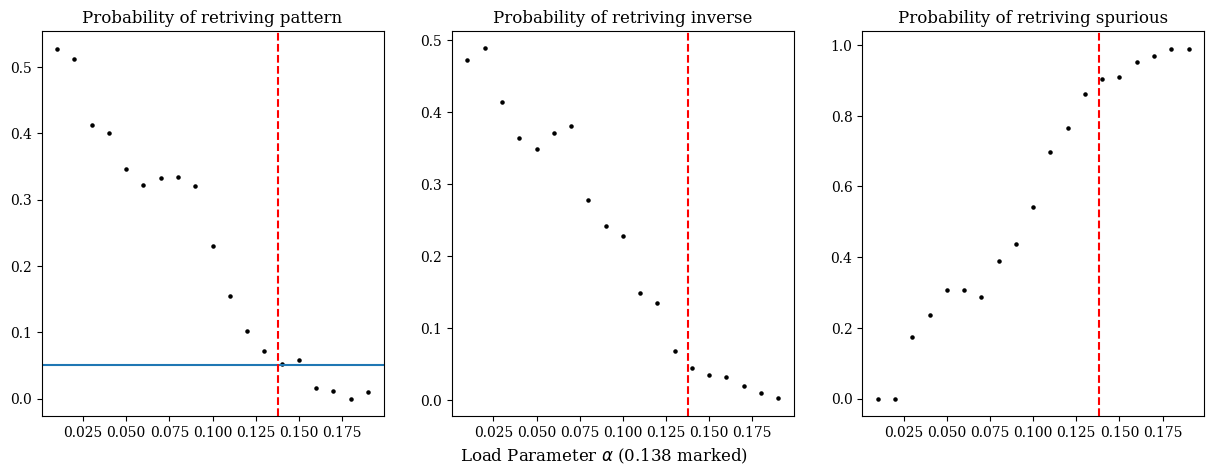

In [513]:
# n_pattern_smooth = savgol_filter(n_pattern, window_length=9, polyorder=2)
# f_pattern = interpolate.interp1d(x=num_pat_arr/L, y=n_pattern_smooth, kind='cubic')
# f_inv = interpolate.interp1d(x=n_pattern_smooth, y=num_pat_arr/L, kind='cubic')
# x = np.arange(0,0.2, 0.001)
# interp_vals = np.interp(x, num_pat_arr/L, n_pattern_smooth)
# print(interp_vals[interp_vals==0.05])

fig, ax = plt.subplots(nrows=1, ncols=3,figsize=(15,5))
ax[0].scatter(num_pat_arr/L, n_pattern, s=5, color='black')
# ax[0].plot(num_pat_arr/L, f_pattern(num_pat_arr/L), color='blue')
# ax[0].plot(f_inv(n_pattern_smooth), n_pattern_smooth, color='red')
# ax[0].plot(num_pat_arr/L, n_pattern_smooth, color='red')
x = np.arange(0,0.2, 0.001)
# ax[0].plot(x, interp_vals, color='green')
ax[0].axhline(y=0.05)
ax[0].axvline(x=0.138, color='red', ls='--')
ax[0].set_title('Probability of retriving pattern')
ax[1].scatter(num_pat_arr/L, n_inverse, s=5, color='black')
ax[1].axvline(x=0.138, color='red', ls='--')
ax[1].set_title('Probability of retriving inverse')
ax[2].scatter(num_pat_arr/L, n_spurious, s=5, color='black')
ax[2].axvline(x=0.138, color='red', ls='--')
ax[2].set_title('Probability of retriving spurious')
fig.supxlabel(r'Load Parameter $\alpha$ (0.138 marked)')
plt.show()

# print(f_inv(0.05))
# print(np.interp(0.05, n_pattern, num_pat_arr/L))

In [642]:
%%time
L_arr = np.arange(100, 700, 50)
N_sweeps = 200
N_avg = 250
N_points = 20
capacity = np.zeros_like(L_arr)
n_pattern_overall = np.zeros((len(L_arr),N_points))
num_pat_overall = np.zeros_like(n_pattern_overall)

for size in tqdm(range(len(L_arr))):
    L = L_arr[size]
    num_pat_arr = np.linspace(1, int(0.2*L), N_points).astype(np.int64)
    n_pattern = np.zeros_like(num_pat_arr)
    n_inverse = np.zeros_like(num_pat_arr)
    n_spurious = np.zeros_like(num_pat_arr)
    energy_arr = np.zeros(shape=(len(num_pat_arr), N_sweeps+1))
    
    for npa in range(0, len(num_pat_arr)):
        num_pat = num_pat_arr[npa]
    
        for avg_no in range(0, N_avg):
            # creating random patterns
            pat_arr =  np.ones((num_pat,L))
            for j in range(num_pat):
                pat_arr[j] = random_config(L)  
            
            spins, pattern, H_arr = hop_run(pattern=pat_arr, T=0.01, N=N_sweeps)
            energy_arr[npa] += H_arr/N_avg
            
            match = 0
            for i in range(num_pat):
                if all(spins==pattern[i]): 
                    n_pattern[npa] += 1
                    match = i+1
                    break
                elif all(-spins==pattern[i]):
                    n_inverse[npa] += 1
                    match = i+1
            if match == 0:
                n_spurious[npa] +=1
    
    n_pattern = (n_pattern+n_inverse)/N_avg
    n_pattern_overall[size] = n_pattern
    num_pat_overall[size] = num_pat_arr
    # n_pattern_smooth = savgol_filter(n_pattern, window_length=13, polyorder=2)
    # f_inv = interpolate.interp1d(x=n_pattern_smooth, y=num_pat_arr/L, kind='cubic')
    # try:
    #     capacity[size] = f_inv(0.05)
    # except:
    #     continue

100%|██████████████████████████████████████████| 12/12 [57:42<00:00, 288.55s/it]

CPU times: user 57min 22s, sys: 9.88 s, total: 57min 32s
Wall time: 57min 42s


In [676]:
# A = np.zeros((3, len(L_arr), N_points))
# A[0][:,0] = L_arr
# A[0][:,1] = capacity_arr_alt
# A[1] = num_pat_overall
# A[2] = n_pattern_overall
# np.save('Capacity_data_2', A)

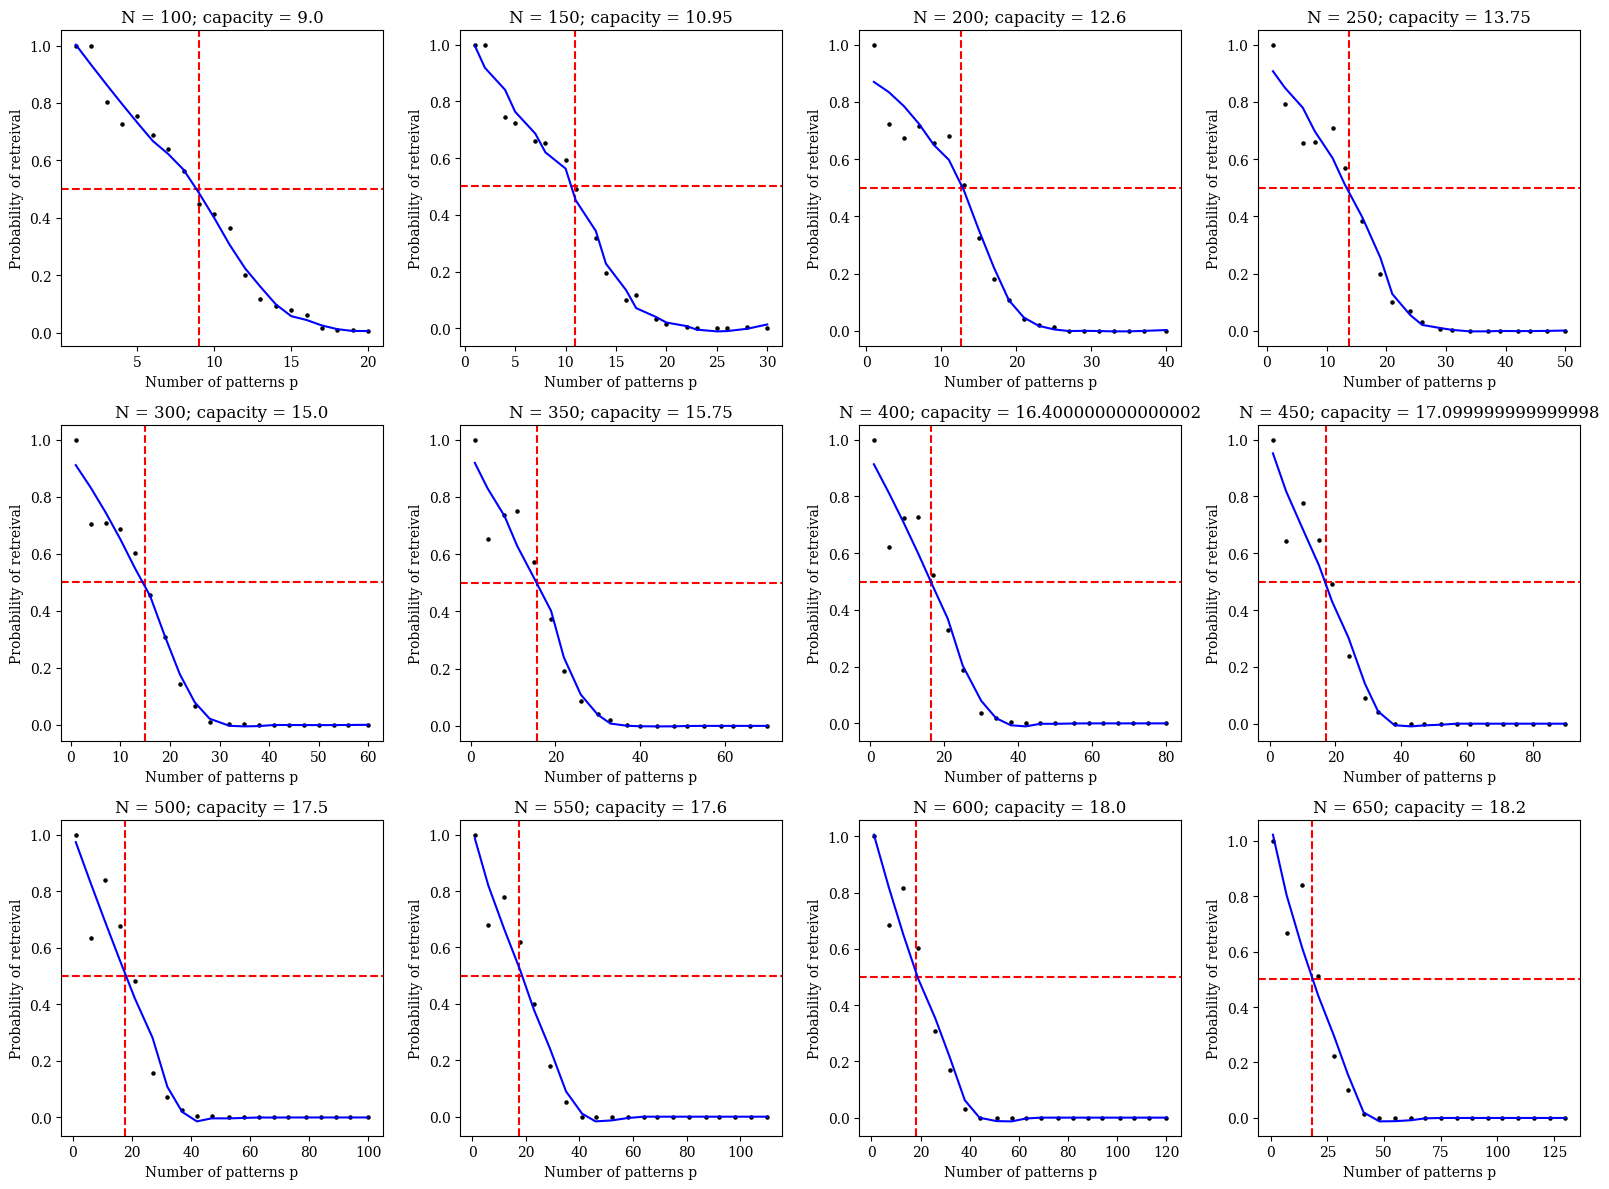

[100 150 200 250 300 350 400 450 500 550 600 650] [0.15  0.12  0.103 0.095 0.088 0.083 0.078 0.07  0.068 0.065 0.063 0.058]


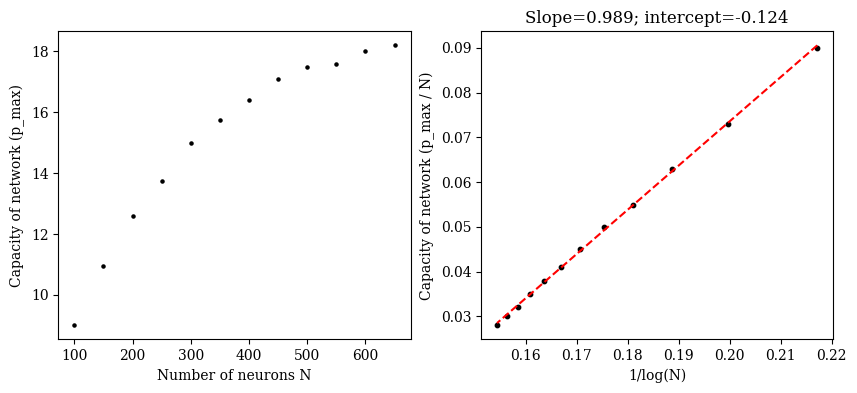

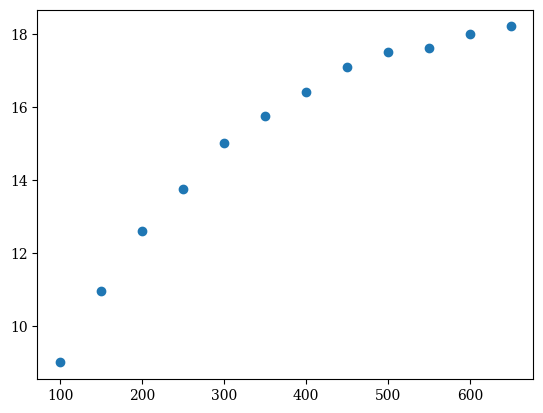

In [831]:
L, pat = np.shape(n_pattern_overall)
fig, ax = plt.subplots(nrows=int(np.ceil(L/4)), ncols=4, figsize=(16,12))
capacity_arr = np.array([0.15,0.12,0.103,0.095,
                         0.088,0.083,0.078,0.07,
                         0.068,0.065,0.063,0.058])
capacity_arr_alt = np.array([0.09,0.073,0.063,0.055,
                             0.05,0.045,0.041,0.038,
                             0.035,0.032,0.03,0.028])
for i in range(int(np.ceil(L/4))):
    for j in range(4):
        L_spec = L_arr[i*4 + j]
        ax[i,j].scatter(num_pat_overall[i*4 + j], n_pattern_overall[i*4 + j], s=5, color='black')
        ax[i,j].axhline(y=0.5, color='red', ls='--')
        ax[i,j].axvline(x=capacity_arr_alt[i*4 + j]*L_spec, color='red', ls='--')
        n_pattern_smooth = savgol_filter(n_pattern_overall[i*4 + j], window_length=9, polyorder=2)
        f_pattern = interpolate.interp1d(x=num_pat_overall[i*4+j], y=n_pattern_smooth, kind='cubic')
        ax[i,j].plot(num_pat_overall[i*4+j], f_pattern(num_pat_overall[i*4+j]), color='blue')
        ax[i,j].set_xlabel(r'Number of patterns p')
        ax[i,j].set_ylabel('Probability of retreival')
        ax[i,j].set_title('N = '+str(L_spec)+'; capacity = '+str(capacity_arr_alt[i*4+j]*L_spec))

# capacity_arr = np.array([0.02,0.012,0.005,0.001])
# for j in range(4):
#     i = 0
#     L_spec = L_arr[i*4 + j]
#     ax[j].scatter(num_pat_overall[i*4 + j]/L_spec, n_pattern_overall[i*4 + j], s=5, color='black')
#     ax[j].axhline(y=0.95, color='red', ls='--')
#     ax[j].axvline(x=capacity_arr[i*4 + j], color='red', ls='--')
#     n_pattern_smooth = savgol_filter(n_pattern_overall[i*4 + j], window_length=9, polyorder=2)
#     f_pattern = interpolate.interp1d(x=num_pat_overall[i*4+j]/L_spec, y=n_pattern_smooth, kind='cubic')
#     ax[j].plot(num_pat_overall[i*4+j]/L_spec, f_pattern(num_pat_overall[i*4+j]/L_spec), color='blue')
#     ax[j].set_xlabel(r'Load Parameter $\alpha$ (p/N)')
#     ax[j].set_ylabel('Probability of retreival')
#     ax[j].set_title('N = '+str(L_spec)+'; capacity = '+str(capacity_arr[i*4+j]))

plt.tight_layout()
plt.show()

print(L_arr, capacity_arr)

fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10,4))
ax[0].scatter(L_arr, capacity_arr_alt*L_arr, color='black', s=5)
ax[0].set_xlabel('Number of neurons N')
ax[0].set_ylabel('Capacity of network (p_max)')

ax[1].scatter(1/np.log(L_arr), capacity_arr_alt, color='black', s=10)
m,c = np.polyfit(1/np.log(L_arr), capacity_arr_alt, 1)
fit = m/np.log(L_arr) + c
ax[1].plot(1/np.log(L_arr), fit, color='red', ls='--')
ax[1].set_title('Slope='+str(np.round(m,3))+'; intercept='+str(np.round(c,3)))
ax[1].set_xlabel('1/log(N)')
ax[1].set_ylabel('Capacity of network (p_max / N)')
plt.show()

plt.scatter(L_arr, capacity_arr_alt*L_arr)
# plt.plot(1/np.log(L_arr), 1/np.log(L_arr)/4)

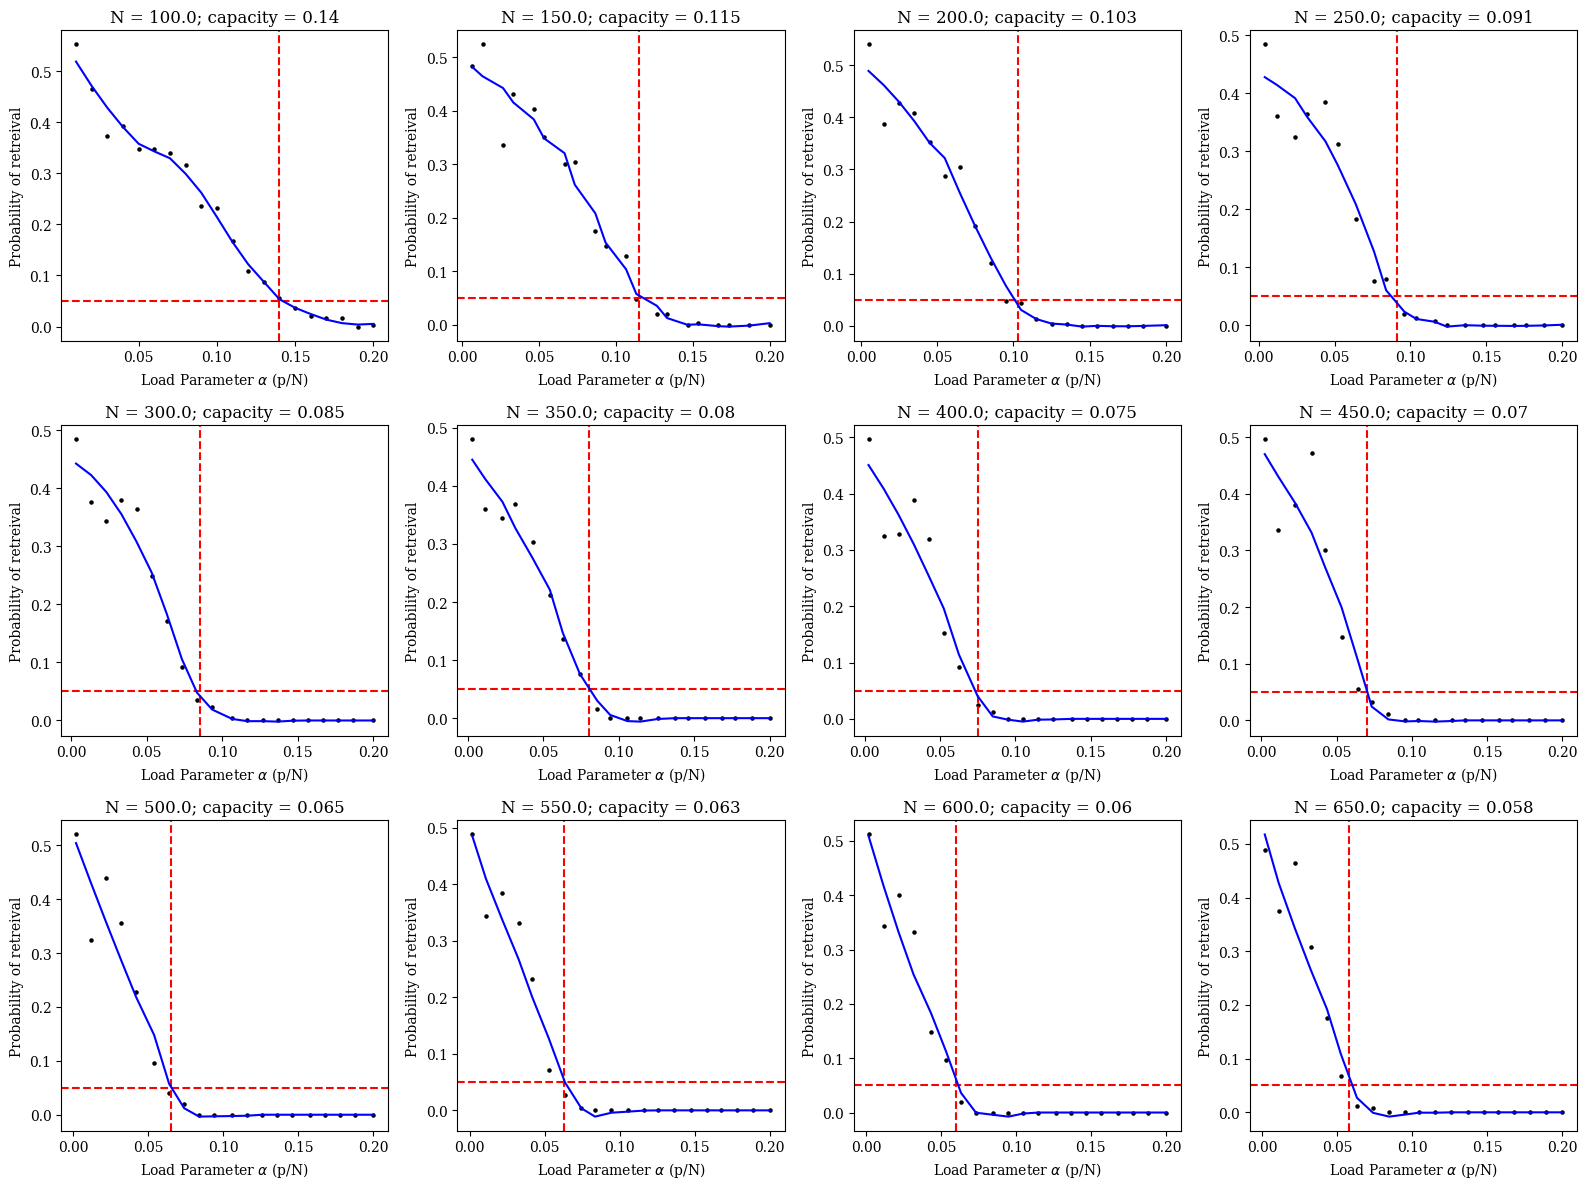

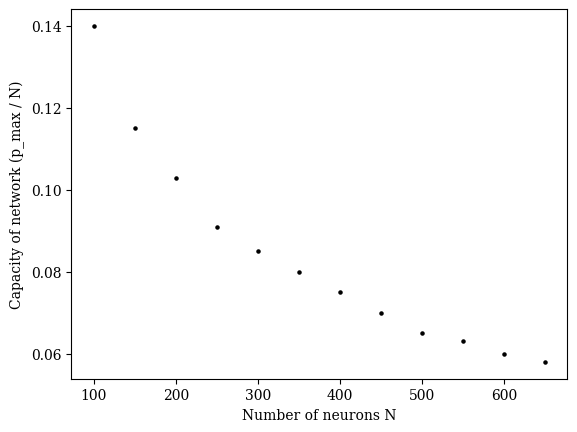

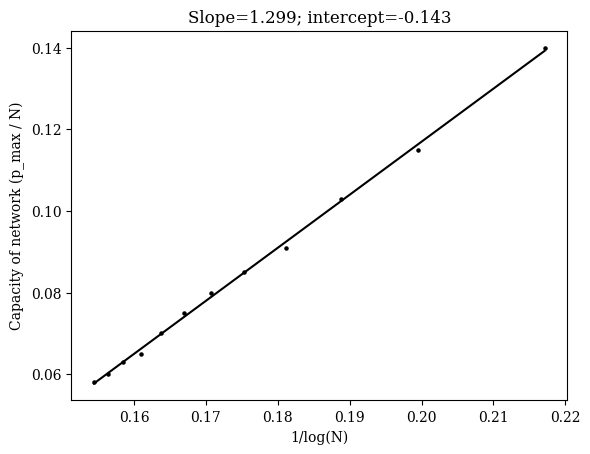

In [609]:
# B = np.load('Capacity_test.npy')
# num_pat_overall = B[1]
# n_pattern_overall = B[2]
# L_arr = B[0][:,0]

# L, pat = np.shape(n_pattern_overall)
# fig, ax = plt.subplots(nrows=int(np.ceil(L/4)), ncols=4, figsize=(16,12))
# capacity_arr = np.array([0.14,0.115,0.103,0.091,0.085,0.08,0.075,0.07,0.065,0.063,0.06,0.058])
# for i in range(int(np.ceil(L/4))):
#     for j in range(4):
#         L_spec = L_arr[i*4 + j]
#         ax[i,j].scatter(num_pat_overall[i*4 + j]/L_spec, n_pattern_overall[i*4 + j], s=5, color='black')
#         ax[i,j].axhline(y=0.05, color='red', ls='--')
#         ax[i,j].axvline(x=capacity_arr[i*4 + j], color='red', ls='--')
#         n_pattern_smooth = savgol_filter(n_pattern_overall[i*4 + j], window_length=9, polyorder=2)
#         f_pattern = interpolate.interp1d(x=num_pat_overall[i*4+j]/L_spec, y=n_pattern_smooth, kind='cubic')
#         ax[i,j].plot(num_pat_overall[i*4+j]/L_spec, f_pattern(num_pat_overall[i*4+j]/L_spec), color='blue')
#         ax[i,j].set_xlabel(r'Load Parameter $\alpha$ (p/N)')
#         ax[i,j].set_ylabel('Probability of retreival')
#         ax[i,j].set_title('N = '+str(L_spec)+'; capacity = '+str(capacity_arr[i*4+j]))

# plt.tight_layout()
# plt.show()
# plt.scatter(L_arr, capacity_arr, color='black', s=5)
# plt.xlabel('Number of neurons N')
# plt.ylabel('Capacity of network (p_max / N)')

# plt.show()
# plt.scatter(1/np.log(L_arr), capacity_arr, color='black', s=5)
# m,c = np.polyfit(1/np.log(L_arr), capacity_arr, 1)
# fit = m/np.log(L_arr) + c
# plt.plot(1/np.log(L_arr), fit, color='black')
# plt.title('Slope='+str(np.round(m,3))+'; intercept='+str(np.round(c,3)))
# plt.xlabel('1/log(N)')
# plt.ylabel('Capacity of network (p_max / N)')
# plt.show()


## Sequences of patterns- definitely more than one going on here onwards
Now the input sequence of patterns is intended to be reached in sequence. So do I start out in the first pattern, or at random again?

Two ways to do this one: first is to animate it and see it go through the sequences? But then I would have to pull up all the sequences as well. Seems not so great. Instead I could calculate the energy at each point and see if it goes through different minima. Track the energy more or less. 

In [381]:
@njit
def energy(spins, w):
    H = 0
    for i in range(L):
        for j in range(L):
            H += w[i][j] * spins[i] * spins[j]
    H = -0.5*H
    return H

@njit
def hop_sweep_seq(spins, w, T):
    L = np.shape(spins)[0]
    for i in range(L):
        rdm_spin = int(L*np.random.uniform(0,1))
        # Stochastic
        h_i = np.sum(w[rdm_spin]*spins)
        f_p = 1/(1+ np.exp(-2*h_i/T))
        r = np.random.uniform(0,1)
        if r<= f_p:
            spins[rdm_spin] = 1
        else:
            spins[rdm_spin] = -1
        
    return spins

# @njit
def hop_run_seq(pattern, T=0.2, lambd=0.9, N=1000):
    shape_arr = np.shape(pattern)
    p = shape_arr[0]
    if p<=1:
        print("Insufficient patterns for the sequence function.")
        return
    else:  # multiple patterns stored
        num_pat, L = np.shape(pattern)
        w = np.zeros((L,L))  # setting the weight array

        # the thing that doesn't work
        for j in range(num_pat):
            for i in range(L):  
                w[i] += pattern[j] * pattern[j][i] /L
                w[i] += (lambd/L) * pattern[(j+1)%p] * pattern[j][i]

    initial_spins =  random_config(L)

    spins = np.copy(initial_spins)
    H_arr = np.zeros(N+1)
    H_arr[0] = energy(spins, w)

    for i in range(N):
        spins = hop_sweep_seq(spins, w, T)
        H_arr[i+1] = energy(spins, w)
        
    return spins, pattern, H_arr

In [382]:
%%time
sqr = 25; L = sqr**2
num_pat = 5
print("Number of patterns:", num_pat)

# creating random patterns to find
pat_arr =  np.ones((num_pat,L))
for j in range(num_pat):
    pat_arr[j] = random_config(L)

N = 1000
spins, pattern, H_arr = hop_run_seq(pattern=pat_arr, T=0.4, lambd=1.5, N=N)

Number of patterns: 5
CPU times: user 1.41 s, sys: 11.1 ms, total: 1.42 s
Wall time: 1.43 s


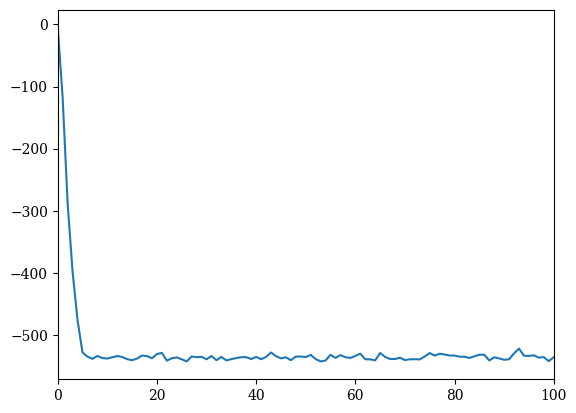

In [383]:
step = np.arange(0, N+1, 1)
plt.plot(step, H_arr)
plt.xlim(0,100)
plt.show()

## Short and Long times

In [338]:
@njit
def energy(spins, w):
    H = 0
    for i in range(L):
        for j in range(L):
            H += w[i][j] * spins[i] * spins[j]
    H = -0.5*H
    return H

def p_overlap(spins, pattern):
    p, L = np.shape(pattern)
    m_arr = np.zeros(p)
    for i in range(p):
        m_arr[i] = 1/L * np.sum(spins*pattern[i])
    return m_arr

@njit
def hop_sweep_sl(spins, w_s, w_l, T, lambd, tau, spins_history, run):
    L = np.shape(spins)[0]
    for i in range(L):
        rdm_spin = int(L*np.random.uniform(0,1))

        #Calculating the kernel K
        spins_dr = spins_history[run-tau]    # Dirac-delta kernel

        # spins_dr = np.zeros_like(spins)        # Step-function kernel
        # for a in range(tau):
        #     spins_dr += spins_history[run-a]/tau
        
        h_i = np.sum(w_s[rdm_spin]*spins) + np.sum(lambd*w_l[rdm_spin]*spins_dr)
        
        f_p = 1/(1+ np.exp(-2*h_i/T))
        r = np.random.uniform(0,1)
        if r<= f_p:
            spins[rdm_spin] = 1
        else:
            spins[rdm_spin] = -1
        
    return spins

def hop_run_sl(pattern, tau, T=0.1, lambd=0.9, N=1000):
    shape_arr = np.shape(pattern)
    p = shape_arr[0]
    if p<=1:
        print("Insufficient patterns for the sequence function.")
        return
    else:  # multiple patterns stored
        num_pat, L = np.shape(pattern)
        w_s = np.zeros((L,L))
        w_l = np.zeros((L,L))
        
        for j in range(num_pat):
            for i in range(L):  
                w_s[i] += pattern[j] * pattern[j][i] /L
                w_l[i] += pattern[j] * pattern[(j+1)%p][i] /L
        
    initial_spins = pattern[0] #random_config(L)

    spins = np.copy(initial_spins)
    H_arr = np.zeros(N+1)
    H_arr[0] = energy(spins, w_s + lambd*w_l)
    overlaps = np.zeros((N+1, p))
    overlaps[0] = p_overlap(spins, pattern)

    spins_history = np.zeros((N+1, L))
    spins_history[0] = np.copy(spins)

    for run in range(N):
        spins = hop_sweep_sl(spins, w_s, w_l, T, lambd, tau, spins_history, run)
        H_arr[run+1] = energy(spins, w_s + lambd*w_l)
        overlaps[run+1] = p_overlap(spins, pattern)
        spins_history[run+1] = np.copy(spins)
        
    return spins, pattern, H_arr, overlaps

In [825]:
%%time
sqr = 15; L = sqr**2
num_pat = 10
print("Number of patterns:", num_pat)

# creating random patterns to find
pat_arr =  np.ones((num_pat,L))
for j in range(num_pat):
    pat_arr[j] = random_config(L)

N = 200
tau = 10
lambd = 1.5
spins, pattern, H_arr, overlaps= hop_run_sl(pattern=pat_arr, tau=tau, T=0.2, lambd=lambd, N=N)

Number of patterns: 10
CPU times: user 71.5 ms, sys: 2.16 ms, total: 73.7 ms
Wall time: 72.3 ms


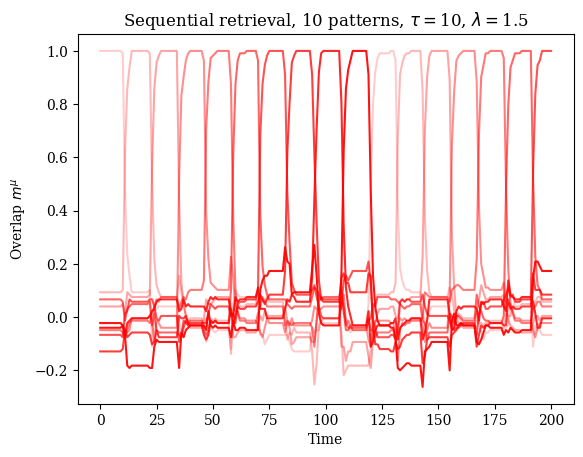

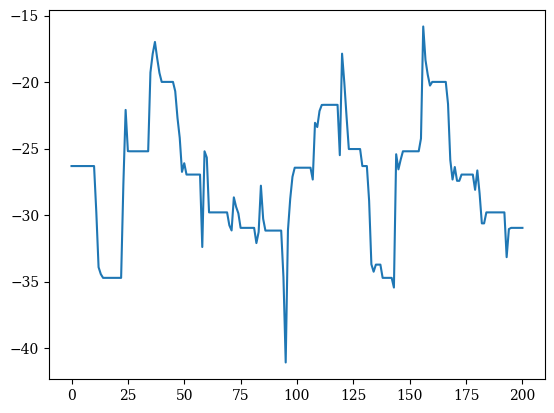

In [826]:
# fig, ax = plt.subplots(nrows=1, ncols=4, figsize=(16,4))
# ax[0].plot(overlaps[:,0])
# ax[1].plot(overlaps[:,1])
# ax[2].plot(overlaps[:,2])
# ax[3].plot(overlaps[:,-1])
# plt.setp(ax, ylim=(-1,1))
# plt.show()


# plt.plot(overlaps[:,0], label="Pattern 1")
# plt.plot(overlaps[:,1], label="Pattern 2")
# plt.plot(overlaps[:,2], label="Pattern 3")
# plt.plot(overlaps[:,-1], label="Pattern 4")
# plt.title(r"Sequential retrieval, $\tau =$"+str(tau)+r", $\lambda =$"+str(lambd))
# plt.ylabel(r"Overlap $m^{\mu}$")
# plt.xlabel("Time")
# plt.legend()
# plt.show()
# plt.plot(H_arr)
# plt.show()

for i in range(num_pat):
    plt.plot(overlaps[:,i], color='red', alpha=0.2 + ((1-0.2)/num_pat)*i)

plt.title(r"Sequential retrieval, 10 patterns, $\tau =$"+str(tau)+r", $\lambda =$"+str(lambd))
plt.ylabel(r"Overlap $m^{\mu}$")
plt.xlabel("Time")
plt.show()
plt.plot(H_arr)
plt.show()